# Bengali Fake News Classification


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install bnlp_toolkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached bnlp_toolkit-3.2.0-py3-none-any.whl (19 kB)
  Using cached gensim-4.0.1-cp38-cp38-manylinux1_x86_64.whl (23.9 MB)
  Using cached sentencepiece-0.1.97-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)
  Using cached sklearn_crfsuite-0.3.6-py2.py3-none-any.whl (12 kB)
  Using cached python_crfsuite-0.9.8-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.0 MB)
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-4.25.1-py3-none-any.whl (5.8 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 91.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 22.2 MB/s eta 0:00:00


In [ ]:
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
from transformers import BertModel, BertTokenizer, BertForSequenceClassification

In [ ]:
class NewsDatasets(Dataset):
    def __init__(self, data, max_length=100):
        self.data = data
        
        self.config = {
            "max_length": max_length,
            "padding": "max_length",
            "return_tensors": "pt",
            "truncation": True,
            "add_special_tokens": True
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        value = self.data.iloc[idx]
        return value['head']+"[SEP]"+value['con'] , value['label']

In [ ]:
from sklearn.model_selection import train_test_split

auth = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Authentic-48K.csv")
fake = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Fake-1K.csv")
df = auth[:fake.shape[0]* 15]

df = df.append(fake)


train_df, test_df = train_test_split(df, test_size=0.10, random_state=121, stratify=df['label'])


df = train_df.append(train_df[train_df['label']==0].sample(len(fake)*20, replace=True))
df = df.sample(frac=1).reset_index(drop=True)
len(df) , len(auth)
train_df=df

In [ ]:
len(train_df)

44685

In [ ]:
train_df[train_df['label']==0].head()

,articleID,domain,date,category,headline,content,label
1,390,channeldhaka.news,2019-04-11T21:09:04+00:00,Miscellaneous,বাংলাদেশি তরুণকে বিয়ে করতে ইসলাম গ্রহণ ম্যাক্স...,প্রেম মানে না কোনো বাধা। প্রেম মানেনা কোনো অনু...,0
2,287,channeldhaka.news,2019-04-29T20:14:50+00:00,Miscellaneous,মিরপুরে বৃষ্টির গুজব! হাজার হাজার মানুষ ছুটছে ...,তীব্র গরমে রাজধানীবাসীর জীবন যায় যায় অবস্থা। এ...,0
3,214,bengalbeats.com,2018-07-24T15:55:39+00:00,Lifestyle,জীবনে কখনো প্রেমে বিচ্ছেদ ঘটেছে? দেখুনতো বিচ্ছ...,"মানুষ প্রেমে পড়লে হালকা বদলে যায়, কথাটি যেমন স...",0
6,151,channeldhaka.news,2019-03-16T10:31:47+00:00,Miscellaneous,"নোয়াখালী চাইলো বিভাগ, আর পেলো রোহিঙ্গা",গত বেশকিছু বছর ধরে নোয়াখালীবাসী ‘নোয়াখালী বিভা...,0
8,483,motikontho.wordpress.com,2014-12-26T22:05:33+00:00,Miscellaneous,"জিহাদ নহে, উহা গোলাম আযমের কান্নার শব্দ: জুনাই...",নিজস্ব মতিবেদকরাজধানীর রাজধানীর শাহজাহানপুরের ...,0


In [ ]:
df.head()

,articleID,domain,date,category,headline,content,label
0,3470,dailyjanakantha.com,2018-09-20 16:36:54,National,বরিশালে হেরোইনসহ বিক্রেতা আটক,"স্টাফ রিপোর্টার, বরিশাল ॥ নগরীর ২৯ নম্বর ওয়ার্...",1
1,390,channeldhaka.news,2019-04-11T21:09:04+00:00,Miscellaneous,বাংলাদেশি তরুণকে বিয়ে করতে ইসলাম গ্রহণ ম্যাক্স...,প্রেম মানে না কোনো বাধা। প্রেম মানেনা কোনো অনু...,0
2,287,channeldhaka.news,2019-04-29T20:14:50+00:00,Miscellaneous,মিরপুরে বৃষ্টির গুজব! হাজার হাজার মানুষ ছুটছে ...,তীব্র গরমে রাজধানীবাসীর জীবন যায় যায় অবস্থা। এ...,0
3,214,bengalbeats.com,2018-07-24T15:55:39+00:00,Lifestyle,জীবনে কখনো প্রেমে বিচ্ছেদ ঘটেছে? দেখুনতো বিচ্ছ...,"মানুষ প্রেমে পড়লে হালকা বদলে যায়, কথাটি যেমন স...",0
4,22552,banglanews24.com,2018-09-28 09:26:35,Politics,সুনামগঞ্জে শিবিরের ১৭ নেতাকর্মী আটক,সুনামগঞ্জ: সুনামগঞ্জের হাসন নগর এলাকায় গোপন বৈ...,1


In [ ]:
from bnlp import BasicTokenizer
from bnlp.corpus import stopwords, punctuations, letters, digits
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()


btokenizer = BasicTokenizer()

def clean_text(text):
    tokens = btokenizer.tokenize(text)
    filtered = []
    for i in tokens:
        i= ps.stem(i)
        if i in stopwords:
            continue
    
        if i in punctuations + '‘' + '’':
            continue
    
        filtered.append(i)
    
    return " ".join(filtered)

print("********** Before ***************")
text = train_df.iloc[1]['content']
print(text)
print("\n********** After ***************")
print(clean_text(text))

punkt not found. downloading...


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


********** Before ***************
প্রেম মানে না কোনো বাধা। প্রেম মানেনা কোনো অনুশাসন। প্রেম মানে না দেশ-কাল, ধর্ম বর্ণ। আর সেই প্রবাদকেই সত্যে পরিণত করে মাঝে মাঝেই বাঙালি ছেলেদের টানে সাত সমুদ্রের ওপার থেকে ছুটে আসেন বিদেশি নারীরা। বিয়ে করে সংসার গড়েন। এবার এক মডেলের প্রেমে পড়ে বাংলাদেশে হাজির হলেন ম্যাক্সিকান তরুণী।তাদের পরিচয় হয় সামাজিক যোগাযোগমাধ্যম ফেসবুকে। আট মাসের প্রণয়কে পরিণয়ে রূপ দিতে বাংলাদেশে ছুটে এলেন ম্যাক্সিকান তরুণী দুলসে আমেরিকা ভ্যালি দিয়েগো। শুধু তাই নয়, বাংলাদেশের উঠতি মডেল অয়ন ওরফে মো. জাবের আলমকে বিয়েও করেন। ৪ এপ্রিল ঢাকার চিফ মেট্রোপলিটন ম্যাজিস্ট্রেট আদালতে দু’জনে বিয়ে করেছেন বলে জানা গেছে।যুক্তরাষ্ট্রের ক্যালিফোর্নিয়া স্টেট ইউনিভার্সিটির দর্শন পড়ুয়া দুলসে ভ্যালি দিয়েগো ভালোবাসার মানুষকে কাছে পেতে খ্রিষ্ট ধর্ম ত্যাগ করে ইসলাম ধর্ম গ্রহণ করেন। ইতিমধ্যে নামের শেষে যুক্ত করেছেন আলম শব্দও।উল্লেখ্য মডেল অয়ন পড়াশোনার পাশাপাশি নিয়মিত মডেলিং করেন।জনপ্রিয় ফ্যাশন হাউস ইজি ও জিরো’র মডেল হয়ে কাজ করেছেন তিনি।সোর্স- দেশ রূপান্তর ShareTweet

********** After ***************
প্র

/usr/local/lib/python3.8/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [ ]:
train_df['head'] = train_df.headline.apply(clean_text)
train_df['con'] = train_df.content.apply(clean_text)
test_df['head'] = test_df.headline.apply(clean_text)
test_df['con'] = test_df.content.apply(clean_text)

from sklearn.model_selection import train_test_split

train_df, testa_df = train_test_split(df, test_size=0.2, random_state=121, stratify=df['label'])

In [ ]:
len(df), len(test_df)

(44685, 2079)

In [ ]:
training_data = NewsDatasets(train_df)
train_dataloader = DataLoader(training_data, batch_size=16, shuffle=True)

In [ ]:
test_data = NewsDatasets(test_df)
test_dataloader = DataLoader(test_data, batch_size=16, shuffle=True)

In [ ]:
class NewsBert(nn.Module):

    def __init__(self, bert):
        super(NewsBert, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.2)

        # relu activation function
        self.relu = nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768, 256)
        # self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 128)

        # dense layer 2 (Output layer)
        self.fc5 = nn.Linear(128, 128)  
        self.fc6 = nn.Linear(128, 2)  

    # define the forward pass
    def forward(self, input_ids, token_type_ids, attention_mask):
        # pass the inputs to the model
        out = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        x = self.fc1(out[1])
        x = self.relu(x)
        x = self.fc2(self.dropout(x))
        x = self.relu(x)
        x = self.fc3(self.dropout(x))
        x = self.relu(x)
        x = self.fc4(self.dropout(x))
        x = self.relu(x)        
        x = self.fc5(self.dropout(x))
        x = self.relu(x)

        # output layer
        x = self.fc6(self.dropout(x))
        
        return x

In [ ]:
bert_model_name = "sagorsarker/bangla-bert-base"
bert = BertModel.from_pretrained(bert_model_name)
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

Downloading:   0%|          | 0.00/491 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/660M [00:00<?, ?B/s]

Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/2.24M [00:00<?, ?B/s]

In [ ]:
# for param in bert.parameters():
#     param.requires_grad = False

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NewsBert(bert)
model.to(device);

In [ ]:
s = "আমি বাংলায় গান গাই। [SEP]"
t = tokenizer.encode_plus(s, return_tensors="pt").to(device)
print(t)
out = model(**t)
print(out)

{'input_ids': tensor([[  101,  2169,  2492,  9294,  2552, 13985,  1014,   102,   102]],
       device='cuda:0'), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}
tensor([[0.1191, 0.0697]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [ ]:
from torch.optim.lr_scheduler import StepLR

optimizer = AdamW(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

# Training

In [ ]:
def train(model, dataloader, optimizer, criterion, config):
    model.train()  # prep model for training
    train_loss = 0
    for batch in tqdm(dataloader):
        text, labels = batch

        model.zero_grad()

        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        logs = model(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss = criterion(logs, labels)
        train_loss += loss.item() * input_ids.size(0)
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

    return train_loss

In [ ]:
def evaluate(model, dataloader, criterion, config):
    total = 0
    correct = 0
    valid_loss = 0.0

    model.eval()  # prep model for evaluation
    for batch in dataloader:
        text, labels = batch
        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        output = model(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss_p = criterion(output, labels)
        # update running validation loss
        valid_loss += loss_p.item() * input_ids.size(0)
        # calculate accuracy
        proba = torch.exp(output)
        top_p, top_class = proba.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        # accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total, correct, valid_loss

In [ ]:
epochs = 10
tokenizer_config = {
    "max_length": 100,
    "padding": "max_length",
    "return_tensors": "pt",
    "truncation": True,
    "add_special_tokens": True
}

In [ ]:
train_loss_data, valid_loss_data = [], []
valid_loss_min = np.Inf
since = time.time()
best_loss = np.inf

for epoch in range(epochs):
    print("Epoch: {}/{}".format(epoch + 1, epochs))
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    total = 0
    correct = 0
    e_since = time.time()

    # Train Model
    train_loss += train(model, train_dataloader, optimizer, criterion, tokenizer_config)
    # Now Evaluate
    out = evaluate(model, test_dataloader, criterion, tokenizer_config)
    total += out[0]
    correct += out[1]
    valid_loss += out[2]
    
    scheduler.step()

    # print training/validation statistics
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_dataloader.dataset)
    valid_loss = valid_loss / len(test_dataloader.dataset)

    # calculate train loss and running loss
    train_loss_data.append(train_loss * 100)
    valid_loss_data.append(valid_loss * 100)
    
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model.state_dict(), "news_model1.pth")

    print("\tTrain loss:{:.6f}..".format(train_loss),
          "\tValid Loss:{:.6f}..".format(valid_loss),
          "\tAccuracy: {:.4f}".format(correct / total * 100))

time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

Epoch: 1/10


  0%|          | 0/2793 [00:00<?, ?it/s]

	Train loss:0.211832.. 	Valid Loss:0.211485.. 	Accuracy: 96.8254
Epoch: 2/10


  0%|          | 0/2793 [00:00<?, ?it/s]

	Train loss:0.028762.. 	Valid Loss:0.368703.. 	Accuracy: 96.0077
Epoch: 3/10


  0%|          | 0/2793 [00:00<?, ?it/s]

	Train loss:0.005798.. 	Valid Loss:0.259630.. 	Accuracy: 97.5950
Epoch: 4/10


  0%|          | 0/2793 [00:00<?, ?it/s]

	Train loss:0.003034.. 	Valid Loss:0.281381.. 	Accuracy: 97.5469
Epoch: 5/10


  0%|          | 0/2793 [00:00<?, ?it/s]

	Train loss:0.000737.. 	Valid Loss:0.288106.. 	Accuracy: 97.5950
Epoch: 6/10


  0%|          | 0/2793 [00:00<?, ?it/s]

	Train loss:0.000851.. 	Valid Loss:0.295862.. 	Accuracy: 97.5469
Epoch: 7/10


  0%|          | 0/2793 [00:00<?, ?it/s]

	Train loss:0.000828.. 	Valid Loss:0.296572.. 	Accuracy: 97.5469
Epoch: 8/10


  0%|          | 0/2793 [00:00<?, ?it/s]

	Train loss:0.000561.. 	Valid Loss:0.297634.. 	Accuracy: 97.5950
Epoch: 9/10


  0%|          | 0/2793 [00:00<?, ?it/s]

	Train loss:0.000461.. 	Valid Loss:0.297649.. 	Accuracy: 97.5950
Epoch: 10/10


  0%|          | 0/2793 [00:00<?, ?it/s]

	Train loss:0.000457.. 	Valid Loss:0.297659.. 	Accuracy: 97.5950
Training completed in 191m 1s


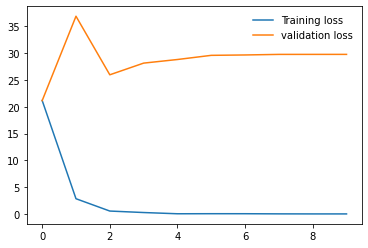

In [ ]:
from matplotlib import pyplot as plt

plt.plot(train_loss_data, label="Training loss")
plt.plot(valid_loss_data, label="validation loss")
plt.legend(frameon=False)

# Testing
To test this model, the left 15% data was used.

In [ ]:
model.load_state_dict(torch.load("./news_model1.pth", map_location = device))

<All keys matched successfully>

In [ ]:
all_preds = []
all_labels = []

for batch in test_dataloader:
    text, labels = batch
    inputs = tokenizer.batch_encode_plus(
        text, **tokenizer_config
    )
    input_ids = inputs['input_ids'].to(device)
    token_type_ids = inputs['token_type_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    labels = labels.to(device)

    # move things to model
    output = model(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)
    preds = output.detach().cpu().numpy()
    preds = np.argmax(preds, axis = 1)
    all_preds.extend(preds)
    all_labels.extend(labels.cpu().numpy())

In [ ]:
from sklearn.metrics import classification_report

# preds = np.argmax(preds, axis = 1)
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.77      0.70      0.73       130
           1       0.98      0.99      0.98      1949

    accuracy                           0.97      2079
   macro avg       0.88      0.84      0.86      2079
weighted avg       0.97      0.97      0.97      2079



#### Thank you very much for reading.
### পড়ার জন্য আপনাকে অনেক ধন্যবাদ।

In [ ]:
 from sklearn import metrics

In [ ]:
confusion_matrix = metrics.confusion_matrix(all_labels, all_preds)



In [ ]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])


In [ ]:
import matplotlib.pyplot as plt



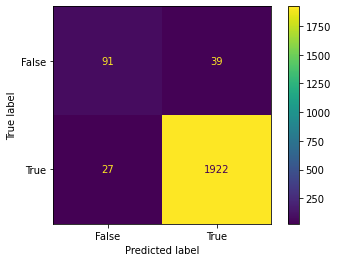

In [ ]:
cm_display.plot()
plt.show()